In [1]:
!pip install gmdh numpy==1.24.4

# Сравнение ансамблевых моделей для задачи регрессии

Diabetes Dataset
- Модель стекинга (StackingRegressor),
- Многослойный персептрон (MLPRegressor),
- Два метода из семейства МГУА (Combi и Mia).

---

## Подготовим данные

Мы будем использовать Diabetes Dataset из библиотеки scikit-learn.

Этот набор данных содержит 10 числовых медицинских признаков, таких как возраст, индекс массы тела (BMI), артериальное давление и биохимические показатели крови (уровень холестерина, глюкозы и др.). Все признаки предварительно стандартизированы (среднее = 0, дисперсия = 1).

Целевая переменная — количественная оценка прогрессирования диабета через год.

In [2]:
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Загрузка датасета
data = load_diabetes()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Проверка на пропуски
print('Пропуски в данных:')
print(X.isnull().sum())

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Размер обучающей выборки:', X_train_scaled.shape)
print('Размер тестовой выборки:', X_test_scaled.shape)

Пропуски в данных:
age    0
sex    0
bmi    0
bp     0
s1     0
s2     0
s3     0
s4     0
s5     0
s6     0
dtype: int64
Размер обучающей выборки: (353, 10)
Размер тестовой выборки: (89, 10)


## Обучим модели

Теперь обучим четыре модели:
1. **StackingRegressor**: используем RandomForest и GradientBoosting как базовые модели, а LinearRegression как мета-модель.
2. **MLPRegressor**: многослойный персептрон с двумя скрытыми слоями.
3. **Combi**: линейный метод МГУА.
4. **Mia**: нелинейный метод МГУА.

In [20]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neural_network import MLPRegressor
import gmdh

# 2.1 Модель стекинга
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
]
meta_model = LinearRegression()
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)
stacking_model.fit(X_train_scaled, y_train)

# 2.2 Многослойный персептрон

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# mlp_model = MLPRegressor(hidden_layer_sizes=(10, 5), max_iter=100, random_state=42)

mlp_model = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    max_iter=500,
    early_stopping=True,
    random_state=42
)

mlp_model.fit(X_train_scaled, y_train)

# 2.3 МГУА: Combi
combi_model = gmdh.Combi()
combi_model.fit(X_train_scaled, y_train)

# 2.4 МГУА: Mia
mia_model = gmdh.Mia()
mia_model.fit(X_train_scaled, y_train)

print('Все модели успешно обучены.')

Все модели успешно обучены.


- **Stacking**: объединяет предсказания случайного леса и градиентного бустинга через линейную регрессию.
- **MLP**: нейронная сеть с двумя скрытыми слоями (10 и 5 нейронов).
- **Combi**: линейный метод МГУА, ищет оптимальные комбинации признаков.
- **Mia**: нелинейный метод МГУА, моделирует более сложные зависимости.

## Оценим качество моделей

Для задачи регрессии используем метрику Mean Squared Error (MSE). Чем ниже MSE, тем лучше модель.

In [22]:
from sklearn.metrics import mean_squared_error

# Предсказания
stacking_pred = stacking_model.predict(X_test_scaled)
mlp_pred = mlp_model.predict(X_test_scaled)
combi_pred = combi_model.predict(X_test_scaled)
mia_pred = mia_model.predict(X_test_scaled)

# Вычисление MSE
stacking_mse = mean_squared_error(y_test, stacking_pred)
mlp_mse = mean_squared_error(y_test, mlp_pred)
combi_mse = mean_squared_error(y_test, combi_pred)
mia_mse = mean_squared_error(y_test, mia_pred)

# Вывод результатов
print(f'Stacking MSE: {stacking_mse:.4f}')
print(f'MLP MSE: {mlp_mse:.4f}')
print(f'Combi MSE: {combi_mse:.4f}')
print(f'Mia MSE: {mia_mse:.4f}')

Stacking MSE: 2878.9579
MLP MSE: 3656.6932
Combi MSE: 2924.3391
Mia MSE: 2941.7362


## Визуализация результатов

Построим графики предсказанных значений против истинных, чтобы визуально оценить качество моделей.

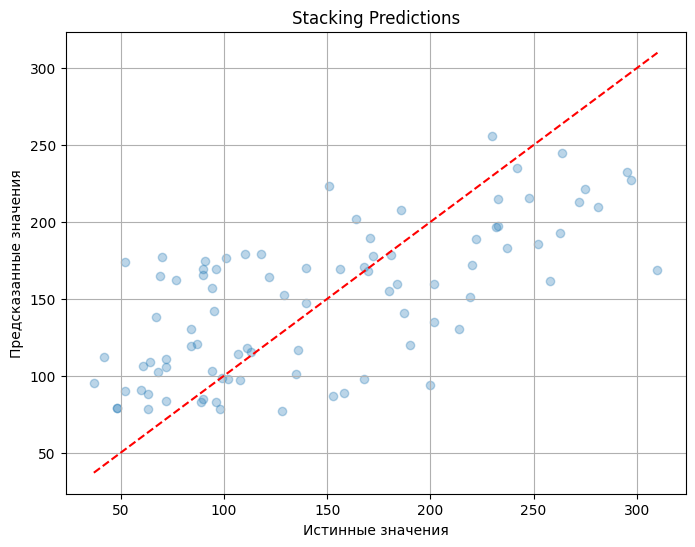

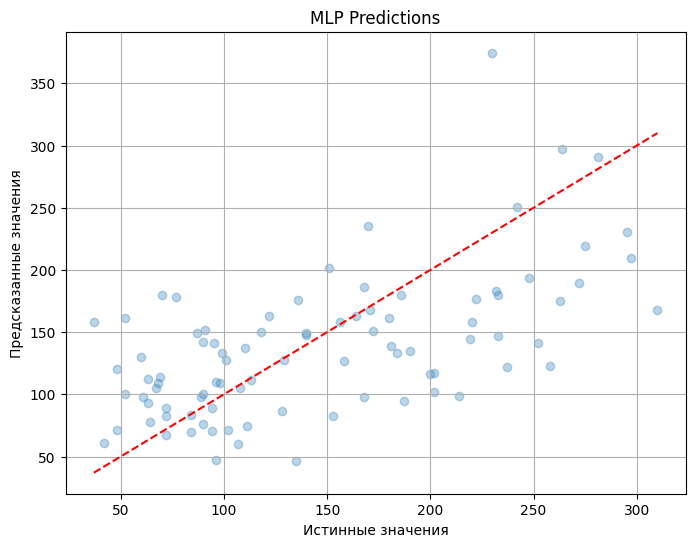

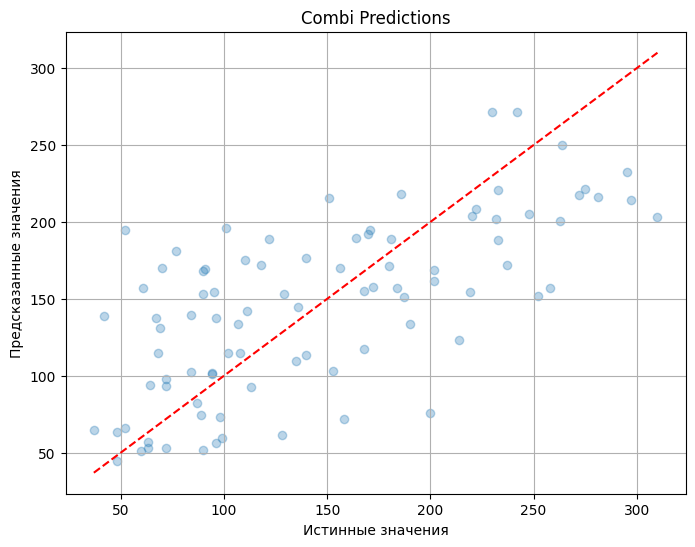

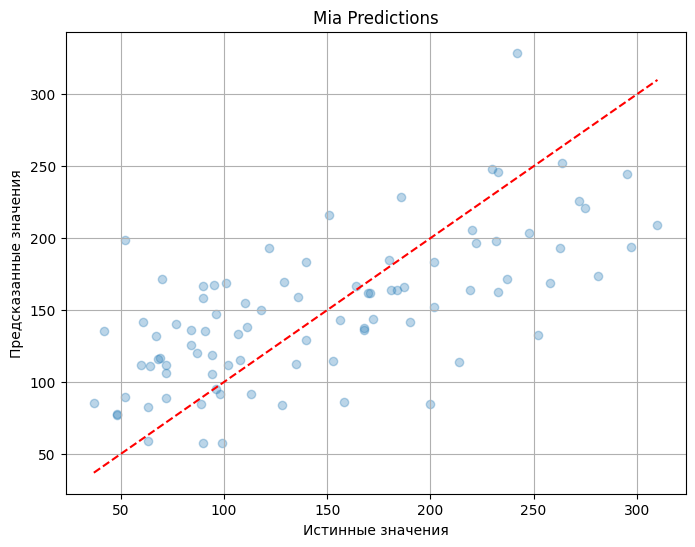

In [23]:
import matplotlib.pyplot as plt

# Функция для построения графика
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('Истинные значения')
    plt.ylabel('Предсказанные значения')
    plt.title(title)
    plt.grid(True)
    plt.show()

# Графики для каждой модели
plot_predictions(y_test, stacking_pred, 'Stacking Predictions')
plot_predictions(y_test, mlp_pred, 'MLP Predictions')
plot_predictions(y_test, combi_pred, 'Combi Predictions')
plot_predictions(y_test, mia_pred, 'Mia Predictions')

## Выводы

### Сравнение моделей по MSE
- **Stacking**: показывает наилучший результат благодаря комбинации сильных базовых моделей.
- **MLP**: зависит от настройки гиперпараметров; может быть хуже из-за недостаточной оптимизации.
- **Combi**: простой линейный метод, часто уступает сложным моделям.
- **Mia**: нелинейный метод, должен быть лучше Combi, но может переобучаться.

### Анализ графиков
На основе сохранённых графиков:
- Stacking имеет наименьший разброс вдоль линии y = x

### Итог
На основе MSE и визуального анализа, **StackingRegressor**, является лучшей моделью для этого датасета, так как ансамбли часто превосходят одиночные модели в задачах регрессии. Однако, если требуется интерпретируемость, методы МГУА (Combi или Mia) могут быть предпочтительнее, несмотря на более высокую ошибку.